# Setup

In [1]:
# repo path & imports
import sys
from pathlib import Path
ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

import numpy as np
import matplotlib.pyplot as plt

from src.io.landuse import load_landuse
from src.models.sw_adapter import rhs
from src.runner import solve_fixed_step

# grid & land-use
Ny, Nx = 128, 192
dx, dy = 1.0 / Nx, 1.0 / Ny
albedo, veg, rough = load_landuse(Ny, Nx)

# 4-field state: [h, u, v, T]
Y0 = np.zeros((4, Ny, Nx), dtype=np.float64)
Y0[0] = 1.0  # depth; u,v,T start at 0

# physics params (toy UHI)
params = {
    "dx": dx, "dy": dy, "g": 9.81, "f": 1e-4, "nu": 1e-4,
    "kT": 1e-3, "Q0": 1.0, "day_len": 1.0, "C_heat": 1.0, "Hc": 0.5, "LEc": 0.4,
    "albedo": albedo, "veg": veg, "roughness": rough,
}

# time step and run params (CFL-safe)
h0 = float(Y0[0].mean())
c0 = (params["g"] * h0) ** 0.5
dx_min = min(dx, dy)
dt = 0.25 * dx_min / c0   # ~3–5e-4 typical; safe start
Tfinal = 1.0
save_every = 200

# output dir
out_dir = ROOT / "outputs" / "uhi_toy"
out_dir.mkdir(parents=True, exist_ok=True)

# Run + end-of-day check

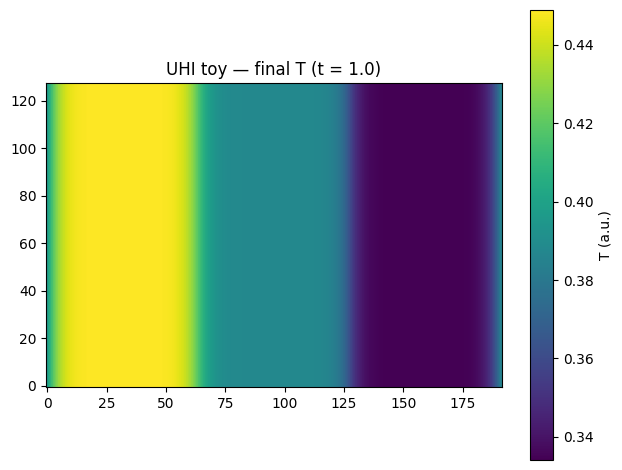

{'asphalt': 0.44298372873804803, 'mixed': 0.3881638798410281, 'park': 0.3391969981768001, 'park_cool_vs_asphalt': 0.10378673056124793}
{'max_cfl': 0.25, 'mean_h_drift_percent': 0.0}


In [2]:
from src.models.sw_adapter import sw_cfl

# run
sol = solve_fixed_step(
    f=rhs,
    t_span=(0.0, Tfinal),
    y0=Y0,
    dt=dt,
    method="rk4",
    params=params,
    save_every=save_every,
    metrics_out_dir=out_dir,
    norm_grid=(dx, dy),
    cfl_specs={
        "gw": {"type": "advection", "dt": dt, "dx": dx_min,
               "u": np.abs(Y0[1]) + np.sqrt(params["g"] * Y0[0])}
    },
)

# save final state & quick plot
h, u, v, T = sol.y[-1]
np.savez(out_dir / "final_state.npz", h=h, u=u, v=v, T=T)

plt.figure(); plt.imshow(T, origin="lower"); plt.colorbar(label="T (a.u.)")
plt.title("UHI toy — final T (t = 1.0)"); plt.tight_layout()
plt.savefig(out_dir / "T_final.png", dpi=160); plt.show()

# bands (mid-row) using land-use masks
row = Ny // 2
asphalt_mask = (veg < 0.05) & (albedo < 0.15)
mixed_mask   = (veg >= 0.05) & (veg < 0.40)
park_mask    = (veg >= 0.40)
a = float(T[row][asphalt_mask[row]].mean())
m = float(T[row][mixed_mask[row]].mean())
p = float(T[row][park_mask[row]].mean())
print({"asphalt": a, "mixed": m, "park": p, "park_cool_vs_asphalt": a - p})

# sanity: CFL & mass drift
max_cfl = max(sw_cfl(Y, params, dt) for Y in sol.y)
mean_h_drift = float(abs(np.mean(sol.y[-1][0]) - np.mean(sol.y[0][0])) / np.mean(sol.y[0][0]) * 100.0)
print({"max_cfl": float(max_cfl), "mean_h_drift_percent": mean_h_drift})

# Mid-day snapshot & ΔT

Using snapshot i=6, t≈0.499
{'midday_asphalt': 0.2595111723535683, 'midday_mixed': 0.22998878056372402, 'midday_park': 0.21024768486059398, 'midday_park_cool_vs_asphalt': 0.04926348749297432}


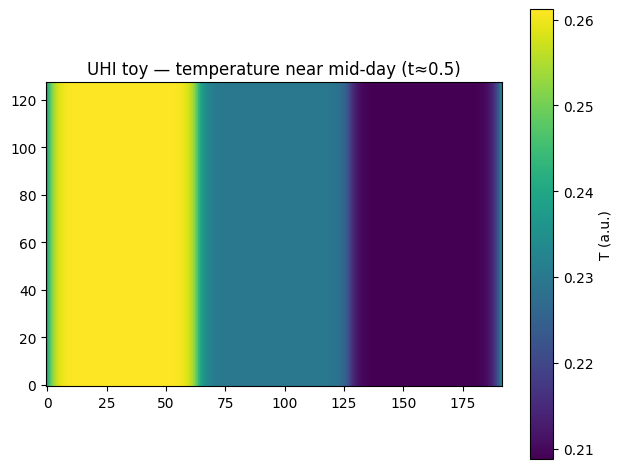

{'cfl_mid': 0.25}


In [3]:
from src.models.sw_adapter import sw_cfl

# snapshot closest to t ≈ 0.5
i_mid = int(np.argmin(np.abs(sol.t - 0.5)))
Y_mid = sol.y[i_mid]
T_mid = Y_mid[3]
print(f"Using snapshot i={i_mid}, t≈{sol.t[i_mid]:.3f}")

# band means on mid-row (robust masks)
row = Ny // 2
asphalt_mask = (veg < 0.05) & (albedo < 0.15)
mixed_mask   = (veg >= 0.05) & (veg < 0.40)
park_mask    = (veg >= 0.40)
a = float(T_mid[row][asphalt_mask[row]].mean())
m = float(T_mid[row][mixed_mask[row]].mean())
p = float(T_mid[row][park_mask[row]].mean())
print({"midday_asphalt": a, "midday_mixed": m, "midday_park": p, "midday_park_cool_vs_asphalt": a - p})

# quick plot
plt.figure()
plt.imshow(T_mid, origin="lower")
plt.colorbar(label="T (a.u.)")
plt.title("UHI toy — temperature near mid-day (t≈0.5)")
plt.tight_layout(); plt.show()

# CFL at this snapshot
cfl_mid = sw_cfl(Y_mid, params, dt)
print({"cfl_mid": float(cfl_mid)})

# Two-city sweep (Cyprus-like vs Rotterdam-like) + metrics dump 

In [4]:
import numpy as np, json
import matplotlib.pyplot as plt
from pathlib import Path
from src.models.sw_adapter import rhs, sw_cfl

def band_means_from(T_field, albedo_field, veg_field):
    """Return band means (asphalt, mixed, park) from land-use masks on a mid row."""
    row = T_field.shape[0] // 2
    asphalt_mask = (veg_field < 0.05) & (albedo_field < 0.15)
    mixed_mask   = (veg_field >= 0.05) & (veg_field < 0.40)
    park_mask    = (veg_field >= 0.40)
    a = float(T_field[row][asphalt_mask[row]].mean())
    m = float(T_field[row][mixed_mask[row]].mean())
    p = float(T_field[row][park_mask[row]].mean())
    return a, m, p

def run_uhi_case(case_name: str, Q0: float, veg_scale: float, albedo_shift: float):
    # clone base params and tweak “climate” knobs
    p = dict(params)
    p["Q0"] = Q0
    p["veg"] = np.clip(p["veg"] * veg_scale, 0.0, 1.0)
    p["albedo"] = np.clip(p["albedo"] + albedo_shift, 0.0, 0.9)

    # output dir per case
    out_case = (out_dir.parent / f"uhi_toy_{case_name}")
    out_case.mkdir(parents=True, exist_ok=True)

    # run
    sol = solve_fixed_step(
        f=rhs, t_span=(0.0, Tfinal), y0=Y0.copy(), dt=dt, method="rk4",
        params=p, save_every=save_every, metrics_out_dir=out_case,
        norm_grid=(dx, dy),
        cfl_specs={"gw": {"type": "advection", "dt": dt, "dx": min(dx, dy),
                          "u": np.abs(Y0[1]) + np.sqrt(p["g"] * Y0[0])}},
    )

    # end-of-day fields
    hF, uF, vF, TF = sol.y[-1]
    np.savez(out_case / "final_state.npz", h=hF, u=uF, v=vF, T=TF)

    # bands @ end and @ mid-day (t≈0.5)
    a_end, m_end, p_end = band_means_from(TF, p["albedo"], p["veg"])
    i_mid = int(np.argmin(np.abs(sol.t - 0.5)))
    T_mid = sol.y[i_mid][3]
    a_mid, m_mid, p_mid = band_means_from(T_mid, p["albedo"], p["veg"])

    # diagnostics
    max_cfl = max(sw_cfl(Y, p, dt) for Y in sol.y)
    mean_h_drift = float(abs(np.mean(sol.y[-1][0]) - np.mean(sol.y[0][0])) /
                         (np.mean(sol.y[0][0]) + 1e-12) * 100.0)

    # plots (optional)
    plt.figure(); plt.imshow(TF, origin="lower"); plt.colorbar(label="T (a.u.)")
    plt.title(f"UHI {case_name} — final T (t=1.0)"); plt.tight_layout()
    plt.savefig(out_case / "T_final.png", dpi=160); plt.close()

    # append to metrics.json
    mfile = out_case / "metrics.json"
    try:
        with mfile.open("r", encoding="utf-8") as fh:
            m = json.load(fh)
    except FileNotFoundError:
        m = {}
    m.setdefault("extras", {}).update({
        "case": case_name,
        "band_means_end":   {"asphalt": a_end, "mixed": m_end, "park": p_end,
                             "park_cool_vs_asphalt": a_end - p_end},
        "band_means_mid":   {"asphalt": a_mid, "mixed": m_mid, "park": p_mid,
                             "park_cool_vs_asphalt": a_mid - p_mid},
        "max_cfl": float(max_cfl),
        "mean_h_drift_percent": mean_h_drift,
        "dt_used": float(dt),
    })
    with mfile.open("w", encoding="utf-8") as fh:
        json.dump(m, fh, indent=2)

    # console summary
    print(f"[{case_name}] end ΔT (asphalt-park): {a_end - p_end:.3f}, mid-day ΔT: {a_mid - p_mid:.3f}, max_cfl: {max_cfl:.3f}")
    return {"case": case_name, "end_delta": a_end - p_end, "mid_delta": a_mid - p_mid, "max_cfl": max_cfl}

# ---- Run both cases ----
cyprus    = run_uhi_case(case_name="cyprus_like",    Q0=2.5, veg_scale=0.7, albedo_shift=-0.02)
rotterdam = run_uhi_case(case_name="rotterdam_like", Q0=1.5, veg_scale=1.4, albedo_shift=+0.02)

print("Summary:", cyprus, rotterdam)

[cyprus_like] end ΔT (asphalt-park): 0.235, mid-day ΔT: 0.117, max_cfl: 0.250
[rotterdam_like] end ΔT (asphalt-park): 0.174, mid-day ΔT: 0.078, max_cfl: 0.250
Summary: {'case': 'cyprus_like', 'end_delta': 0.23478770693910045, 'mid_delta': 0.1173855498784665, 'max_cfl': np.float64(0.25)} {'case': 'rotterdam_like', 'end_delta': 0.1738478710320457, 'mid_delta': 0.0782638255487621, 'max_cfl': np.float64(0.25)}


# Save comparison plot + CSV log


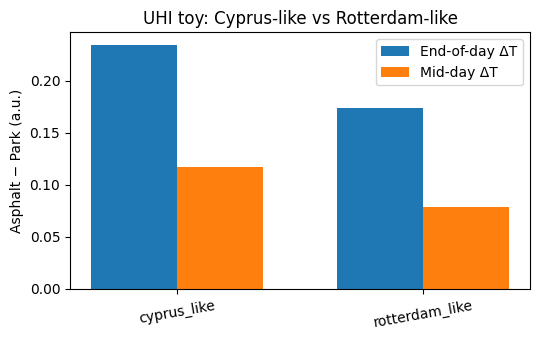

Saved: /Users/linearityproductions/Desktop/meteo_utils/outputs/uhi_toy_summary/two_city_deltaT.png and /Users/linearityproductions/Desktop/meteo_utils/outputs/uhi_toy_summary/two_city_deltaT.csv


In [5]:
import matplotlib.pyplot as plt
from csv import DictWriter
from pathlib import Path

results = [
    {"case": "cyprus_like",    "end_delta": float(cyprus["end_delta"]),    "mid_delta": float(cyprus["mid_delta"]),    "max_cfl": float(cyprus["max_cfl"])},
    {"case": "rotterdam_like", "end_delta": float(rotterdam["end_delta"]), "mid_delta": float(rotterdam["mid_delta"]), "max_cfl": float(rotterdam["max_cfl"])},
]

# 1) Bar plot
cases = [r["case"] for r in results]
end_vals = [r["end_delta"] for r in results]
mid_vals = [r["mid_delta"] for r in results]

plt.figure(figsize=(5.5,3.5))
x = range(len(cases))
w = 0.35
plt.bar([xi - w/2 for xi in x], end_vals, width=w, label="End-of-day ΔT")
plt.bar([xi + w/2 for xi in x], mid_vals, width=w, label="Mid-day ΔT")
plt.xticks(list(x), cases, rotation=10)
plt.ylabel("Asphalt − Park (a.u.)")
plt.title("UHI toy: Cyprus-like vs Rotterdam-like")
plt.legend()
cmp_dir = out_dir.parent / "uhi_toy_summary"
cmp_dir.mkdir(parents=True, exist_ok=True)
plt.tight_layout(); plt.savefig(cmp_dir / "two_city_deltaT.png", dpi=160); plt.show()

# 2) CSV log (append)
csv_path = cmp_dir / "two_city_deltaT.csv"
fields = ["case", "end_delta", "mid_delta", "max_cfl"]
write_header = not csv_path.exists()
with csv_path.open("a", newline="", encoding="utf-8") as f:
    wri = DictWriter(f, fieldnames=fields)
    if write_header: wri.writeheader()
    for r in results: wri.writerow(r)

print("Saved:", cmp_dir / "two_city_deltaT.png", "and", csv_path)